<a href="https://colab.research.google.com/github/restrepo/articles_COVID-19/blob/master/lens_scotogenic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lens API search for Scotogenic in Lens
* 5,000 API requests and up to 5 million records per month
* 10 API requests/minute and up to 1,000 records per request: `sleep=6`

Check: https://docs.api.lens.org/request.html

Get token: https://www.lens.org/lens/user/subscriptions

Examples: https://github.com/cambialens/lens-api-doc

### Design. 
* The `query` search for exact match of any type: title, abstract, affiliation, etc.
* The `query_terms` search for a list of maximum 20 identifiers
* The `query_ORAND` search for a list of type: title, abstract, full_text  etc, words (phrases) with `match_type=match[_phrase]`. For example `title=['first','second','third']`.
    * By default the OR search is done in title, abstract and full_text search

## Functions and global variables

In [0]:
import getpass
import pandas as pd
import requests
import sys
import time
import os
import datetime
if os.getcwd()=='/content':
    !pip install unidecode
    !mkdir data
import unidecode    

     |████████████████████████████████| 245kB 2.7MB/s 


<!-- #666mmkP9Ibp7bDpLNLKZF8bdYDxCQmxXhFuJzJViVKH92kyBlGmatE2888
 -->

In [0]:
token=getpass.getpass('token:')

token:··········


In [0]:
url = 'https://api.lens.org/scholarly/search'
size=1000

In [0]:
def ORKEYS(key,l,kwargs):
    ll=[ {  kwargs['match_type']:{key: unidecode.unidecode(q)} } for q in l]
    if kwargs['abstract']==True:
        ll=ll+[ {  kwargs['match_type']:{'abstract': unidecode.unidecode(q)} } 
                 for q in l]
        ll=ll+[ {  kwargs['match_type']:{'full_text': unidecode.unidecode(q)} } 
                 for q in l]
    return str(ll).replace("'",'"')

def query_terms(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
      lens_id=list of identifiers
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
    """
    key=list(kwargs.keys())[0]
    l=kwargs[key]
    if isinstance(l,list):
        if len(l)>20:
            print('WARNING: Only first 20 items will be searched')
        ls=str(l).replace("'",'"')
    else:
        sys.exit( 'ERROR: {} must be a list'.format(k) )

    data='''{
    "query": {
        "terms": {
			"%s": %s
		}
     }
    }''' %(key,ls )
    return data

def query(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
     query type must be go first! Example: title, affiliation, abstract, etc:
     For example for `title`:
      title="covid-19" #(or Affiliation o lens_id, or ...) 
      match_type ='match_phrase' #for exact match, or match for OR between words
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
    """
    key=list(kwargs.keys())[0]
    q=unidecode.unidecode(kwargs[key])
    #Set default values
    if not kwargs.get('match_type'):
        kwargs['match_type']='match_phrase'
    if not kwargs.get('size'):
        kwargs['size']=1000
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
           "%s":{
                    "%s": "%s"
               }
           },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(kwargs['match_type'],key,q,
                 kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data


def query_ORAND(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
     query type must be go first! Example: title, affiliation, abstract, etc:
     For example for `title`:
      title="covid-19" #(or Affiliation o lens_id, or ...) 
      match_type ='match_phrase' #for exact match, or match for OR between words
      abstract=bolean. Deafult True. Include query in abstract
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000,
      abstract=True # Search also in abstract 
    """
    key=list(kwargs.keys())[0]
    l=kwargs[key]
    if not isinstance(l,list):
        sys.exit('{} must be a list'.format(key))
    #Set default values
    if not kwargs.get('match_type'):
        kwargs['match_type']='match_phrase'
    if not kwargs.get('size'):
        kwargs['size']=1000
    if kwargs.get('logical')=="AND":
        logical='must'
    else:
        kwargs['logical']="OR"
        logical='should' 
    if not kwargs.get('abstract'):
        if kwargs['logical']=="AND":
            kwargs['abstract']=False
        else:
            kwargs['abstract']=True
    if not kwargs.get('logical'):
        kwargs['logical']="OR"
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
            "bool": {
               "%s": %s
                    }
               },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(logical,
           ORKEYS(key,l,kwargs),
                 kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data


def get_query(*args,**kwargs):
    '''
    Use the lens.org API to obtain a DataFrame with the query

    Parameters
    ----------
      data_function: function to generate the data query. See query(...)
      title="covid-19" #(or Affiliation o lens_id, or ...)
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
      url=API_url,
      token=token #API token  
    '''
    query=args[0]
    token=kwargs.get('token')
    url=kwargs.get('url')
    kk=kwargs.pop('url')
    kk=kwargs.pop('token')
    data=query(**kwargs)
    headers = {'Authorization': '{}'.format(token), 'Content-Type': 'application/json'}
    response = requests.post(url, data=data, headers=headers)
    if response.status_code != requests.codes.ok:
        print(response.status_code)
        r='[]'
    else:
        r=response.text
    return pd.read_json(r)    


In [0]:
RELOAD=True
#https://link.lens.org/eBV1zZsBGQd
querylist=["dark matter","neutrino"]
rr=pd.DataFrame()
start_date=datetime.datetime.strptime('1920-01-01','%Y-%m-%d')
#start_date=datetime.datetime.strptime('2020-03-03','%Y-%m-%d')
today=datetime.datetime.today()
dd=['2014-12-31',today.strftime('%Y-%m-%d')]
#dd=['2020-03-02']
for d in dd:
    if not RELOAD:
        break
    next_date=datetime.datetime.strptime(d,'%Y-%m-%d')
    if next_date.date()==today.date():
        rr.to_json('data/scotogenic_{}.json.gz'.format(
             (start_date-datetime.timedelta(days=1)).strftime('%Y-%m-%d')   ))

    print('{} → {} : '.format( start_date.strftime('%Y-%m-%d'),
                              next_date.strftime('%Y-%m-%d') ),
          end='')
    tmp=get_query(query_ORAND,
      title=querylist,
      logical="AND",
      abstract=False,
      range_type="date_published",
      date_ini=start_date.strftime('%Y-%m-%d'),
      date_end=next_date.strftime('%Y-%m-%d'),
      size=1000,
      url=url,
      token=token) 

    print(tmp.shape)
    rr=rr.append( tmp  ).reset_index(drop=True)
    start_date=next_date+datetime.timedelta(days=1)
    
    #if d==dd[0]:
    #    break   
    time.sleep(7)


1920-01-01 → 2014-12-31 : (923, 3)
2015-01-01 → 2020-04-13 : (809, 3)


### Check results

In [0]:
if RELOAD:
    cv=pd.DataFrame(list(rr.data.values))
    cv.to_json('data/scotogenic.json.gz')
else:
    urljason='https://github.com/restrepo/lensapi/raw/master/data/scotogenic.json.gz'
    cv=pd.read_json(urljason,compression='gzip')

In [0]:
cv.shape

(1732, 29)

In [0]:
cv.scholarly_citations_count.sum()

33586.0

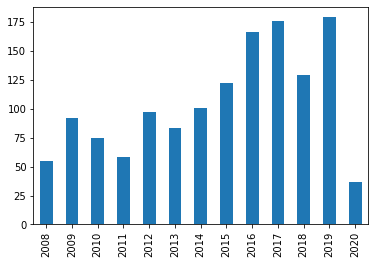

In [0]:
cv['Year']=cv.date_published.apply(lambda s: s.split('-')[0] if type(s)==str else 
                                          s.get('date').split('-')[0] )
cv=cv[~cv['Year'].isna()].reset_index(drop=True)
cv['Year']=cv['Year'].astype(int)
cv[cv['Year']>2007]['Year'].value_counts().sort_index().plot(kind='bar')

### Search for citations

In [0]:
import os
if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Lens.org allows to search for a list of idintifiers ot length until 20

In [0]:
l=list(cv['scholarly_citations'].apply(pd.Series).stack().unique())
len(l)

11575

In [0]:
cvc=pd.DataFrame()
rold=0
terms_max=20
lenl=len(l)
steps=list(range(0,lenl,terms_max))[1:]+[ lenl ]
for r in steps:
    ll=l[rold:r]
    rold=r
    #make lens query
    tmp=get_query(query_terms,lens_id=ll,url=url,token=token)
    cvc=cvc.append(tmp).reset_index(drop=True)
    cvc.to_json('scotogenic_scholarly_citations.json')
    if os.getcwd()=='/content':
        !cp scotogenic_scholarly_citations.json drive/My\ Drive
        
    time.sleep(7)
    #break    

In [0]:
import pandas as pd
cvc=pd.read_json("drive/My Drive/scotogenic_scholarly_citations.json")

In [0]:
dfcvc=pd.DataFrame(list(cvc.data.values))

In [0]:
dfcvc[:14000].to_json('scotogenic_scholarly_citations_part_1.json.gz')
dfcvc[14000:].to_json('scotogenic_scholarly_citations_part_2.json.gz')

In [0]:
ls -lh scotogenic_scholarly_citations_part_*

-rw-r--r-- 1 root root  23M Apr  8 16:45 covid_19_scholarly_citations_part_1.json.gz
-rw-r--r-- 1 root root 8.1M Apr  8 16:45 covid_19_scholarly_citations_part_2.json.gz


In [0]:
dfcvc.columns

Index(['lens_id', 'created', 'open_access', 'publication_type',
       'publication_supplementary_type', 'authors', 'title', 'volume', 'issue',
       'languages', 'references', 'mesh_terms', 'chemicals', 'fields_of_study',
       'funding', 'source_urls', 'abstract', 'year_published',
       'references_count', 'scholarly_citations_count', 'external_ids',
       'start_page', 'end_page', 'source', 'scholarly_citations',
       'author_count', 'date_published', 'keywords', 'patent_citations',
       'patent_citations_count', 'conference', 'clinical_trials'],
      dtype='object')

# Pajek files generation

In [0]:
import pandas as pd
import time
qq=[]
def to_pajek(row,newlist=qq):
    c=len(row.get('scholarly_citations'))
    for i in range(c):
        qq.append({ 'lens_id': row.get('lens_id'),'scholarly_citations': row.get('scholarly_citations')[i] })
    return 'qq is being build'
def to_authors(row,newlist=qq):
    try:
        c=len(row.get('authors'))
    except:
        c=0
    for i in range(c):
        try:
            i_author=row.get('authors')[i]
        except:
            i_author={}
        try:
            i_affiliations=i_author.get('affiliations')[0]
        except:
            i_affiliations={}
        qq.append({ 'lens_id': row.get('lens_id'),
                   'author': '{} {}'.format(i_author.get('first_name'),
                                            i_author.get('last_name')),
                   'affiliation': i_affiliations.get('name'),
                   'country': i_affiliations.get('country_code')})
    return qq#'qq is being build'

In [0]:
base='https://github.com/restrepo/articles_COVID-19/raw/master/data/'
file='scotogenic.json.gz'
cv=pd.read_json('{}{}'.format(base,file),compression='gzip')
time.sleep(2)
file='scotogenic_scholarly_citations.json.gz'
cvc=pd.read_json('{}{}'.format(base,file),compression='gzip')

In [7]:
qq=[]
#remove articles without citations
cvac=cv.dropna(subset=['scholarly_citations'])
cvac.apply( 
    to_pajek ,axis='columns')

0       qq is being build
2       qq is being build
3       qq is being build
5       qq is being build
8       qq is being build
              ...        
1724    qq is being build
1726    qq is being build
1727    qq is being build
1729    qq is being build
1731    qq is being build
Length: 1146, dtype: object

In [0]:

pcvac=pd.DataFrame(qq)
pcvac.to_excel('scotogenic_pajek_hoja_1.xlsx',index=False)

In [12]:
cvt=cvac.append(cvc).reset_index(drop=True)
cvt=cvt.drop_duplicates('lens_id').reset_index(drop=True)
cvt.shape

(11917, 31)

In [0]:
qq=[]
cvt.apply(to_authors,axis='columns').values

In [0]:
pcvt=pd.DataFrame(qq)
pcvt.to_excel('scotogenic_pajek_hoja_3.xlsx',index=False)

In [0]:
cvt['date']=cvt.created.str.split('T').str[0]
cvt['journal']=cvt.source.apply(lambda d: d.get('title') if isinstance(d,dict) else '')
cvt[['lens_id','title','date','journal']].to_excel('scotogenic_pajek_hoja_2.xlsx',index=False)